## Question 3: Hierarchical Clustering

In [1]:
# imports
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import pandas as pd
import numpy as np

In [4]:
# reading the data in pandas dataframe
football = pd.read_csv('./../../football_data.csv', index_col=0)

### Pre-processing

In [5]:
# Step 1: Extract numerical features
num_data = football.select_dtypes(include=[np.number])
# replacing missing values with mean value of that column
data = num_data.fillna(num_data.mean())
# removing ordinal feature 'ID'
data.drop('ID', axis=1, inplace=True)

In [6]:
data.head()

,Age,Overall,Potential,Special,International Reputation,Weak Foot,Skill Moves,Jersey Number,Crossing,Finishing,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,31,94,94,2202,5.0,4.0,4.0,10.0,84.0,95.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,33,94,94,2228,5.0,4.0,5.0,7.0,84.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,26,92,93,2143,5.0,5.0,5.0,10.0,79.0,87.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,27,91,93,1471,4.0,3.0,1.0,1.0,17.0,13.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,27,91,92,2281,4.0,5.0,4.0,7.0,93.0,82.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


### Part 1: Agglomerative Clustering
We use sklearn library which has implementation of agglomerative clustering algorithm.

In [7]:
# imports
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc

In [8]:
X = data    # creating a copy of data for reuse

In [10]:
# Scaling the data so that all the features become comparable
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
  
# Normalizing the data so that the data approximately follows a Gaussian distribution
X_normalized = normalize(X_scaled)

# Applying dimensionality reduction to the data using Principal Component Analysis
# comment following code if you don't want to use the PCA algorithm
pca = PCA(n_components=2)
X_principal = pca.fit_transform(X_normalized)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2']

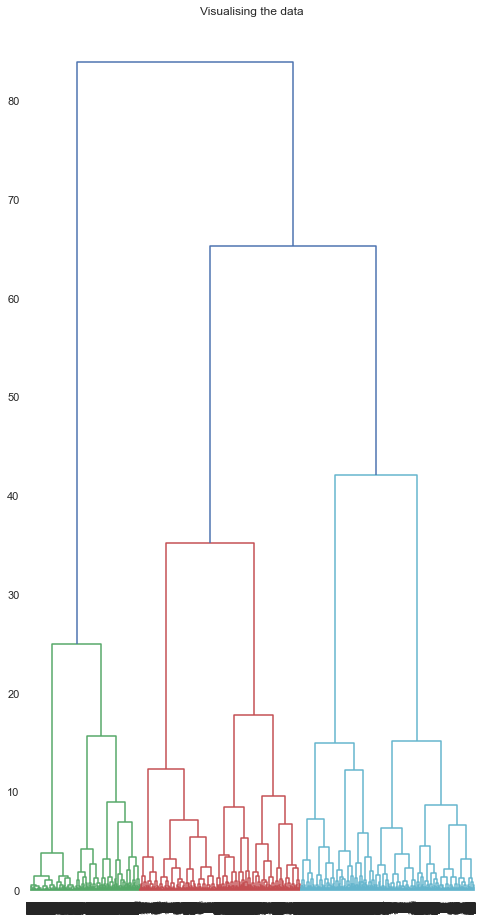

In [11]:
plt.figure(figsize =(16, 12))
plt.title('Visualising the data')
Dendrogram = shc.dendrogram((shc.linkage(X_principal, method ='ward')))

#### using the dendrogram above, we can infer that optimal number of clusters can be 2 or 4. Checking the cluster quality with both of these values


In [12]:
ac2 = AgglomerativeClustering(n_clusters = 2)
ac2_result = ac2.fit_predict(X_principal)

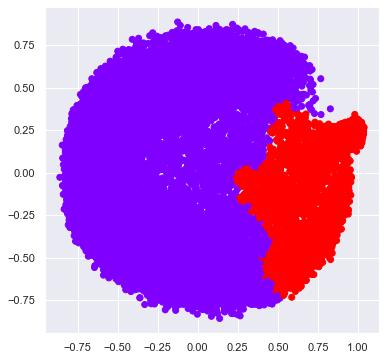

In [13]:
# Visualizing the clustering
plt.figure(figsize =(6, 6))
plt.scatter(X_principal['P1'], X_principal['P2'], c = ac2_result, cmap ='rainbow')
plt.show()

In [14]:
ac4 = AgglomerativeClustering(n_clusters = 4)
ac4_result = ac4.fit_predict(X_principal)

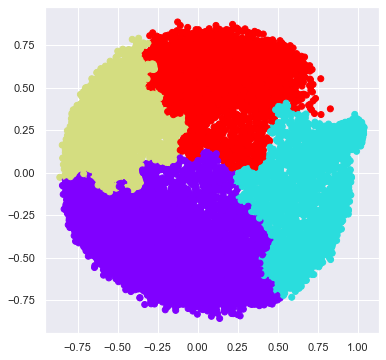

In [15]:
# Visualizing the clustering
plt.figure(figsize =(6, 6))
plt.scatter(X_principal['P1'], X_principal['P2'], c = ac4.fit_predict(X_principal), cmap ='rainbow')
plt.show()

Comparing the cluster quality with k=2 and k=4

In [16]:
print("Silhoutee result for k=2: ", silhouette_score(X_principal, ac2_result))
print("Silhoutee result for k=4: ", silhouette_score(X_principal, ac4_result))


Silhoutee result for k=2:  0.39531409117256916
Silhoutee result for k=4:  0.3984029909939727


## Part 2: Divisive clustering

In [2]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
import copy
from sklearn.preprocessing import StandardScaler, normalize
from scipy.spatial.distance import cdist
import pandas as pd
import matplotlib.image as img

In [ ]:
class DivisiveClustering:
	'''
	Class which implements the DIANA (Divisive Analysis) algorithm and provides an interface for using the implementation.
	'''
	def __init__(self):
		'''
		Initializer for the DivisiveClustering class.
		This function initializes some important class variables.
		'''
		self.clusters={}
		self.dist_matrix=None
		self.mapping=None
		self.no_clusters=0
		self.linkage_matrix=None
		self.n=None
		self.hierarchical_clusters={}
		self.last_index=None

	def initialize(self):
		'''
		Initializer for the DivisiveClustering class.

		Parameters
		----------
		path : string
		    path to file containinng transactions.
		
		Returns
		----------
		transactions : list
			list containing all transactions. Each transaction is a list of
			items present in that transaction.
		items : list
			list containing all the unique items.
		'''
		self.n=len(self.mapping)
		self.last_index=2*self.n-2
		self.i=0
		self.clusters[self.last_index]=list(self.mapping.keys())
		self.linkage_matrix=np.zeros([self.n-1, 4])

	def splinter(self):
		'''
		This function finds the cluster with the largest diameter and finds the splinter element.

		Returns
		----------
		splinter_element : int
			the splinter element. This element will be removed from the cluster that is being split.
		max_diameter_cluster : int
			index of the cluster with the largest diameter. This is the cluster which will be split.
		'''
		cluster_diameters={k:(len(v)<1)*(-1)+(len(v)>1)*np.max(self.dist_matrix[np.ix_(v,v)]) for k,v in self.clusters.items()}
		max_diameter_cluster=max(cluster_diameters, key=cluster_diameters.get)
		avg_within_cluster_distances={pt:(np.sum(self.dist_matrix[np.ix_(self.clusters[max_diameter_cluster], [pt])])/(len(self.clusters[max_diameter_cluster])-1)) for pt in self.clusters[max_diameter_cluster]}
		splinter_element=max(avg_within_cluster_distances, key=avg_within_cluster_distances.get)
		self.no_clusters+=1
		return splinter_element, max_diameter_cluster

	def reassign(self, splinter_element, orig_cluster_key):
		'''
		Function which reassigns points between the original cluster and the splinter cluster.

		Parameters
		----------
		splinter_element : int
		    the splinter element.

		orig_cluster_key : int
		    the ID of the element to be split.

		'''
		# Create temp clusters
		temp_new_cluster=[splinter_element]
		self.clusters[orig_cluster_key].remove(splinter_element)
		temp_orig_cluster=self.clusters[orig_cluster_key]

		# Remove orig cluster from cluster dict
		del self.clusters[orig_cluster_key]

		# Calculate distances
		within_cluster_dist={pt:np.mean(self.dist_matrix[np.ix_(temp_orig_cluster,[pt])]) for pt in temp_orig_cluster }
		dist_to_splinter={pt:self.dist_matrix[pt, splinter_element]  for pt in temp_orig_cluster}
		dist_diff={pt:(within_cluster_dist[pt] - dist_to_splinter[pt]) for pt in temp_orig_cluster} # if +ve, move to splinter
		
		# Reassign points
		for pt in temp_orig_cluster:
			if dist_diff[pt]>0 and len(temp_orig_cluster)>1:
				temp_new_cluster.append(pt)
				temp_orig_cluster.remove(pt)
		
		dist_bw_clusters=np.max(self.dist_matrix[np.ix_(temp_orig_cluster, temp_new_cluster)])
		
		# Add temp clusters to cluster dict
		if len(temp_orig_cluster)==1:
			self.clusters[temp_orig_cluster[0]]=temp_orig_cluster
			orig_cluster_key=temp_orig_cluster[0]
		else:
			self.last_index-=1
			self.clusters[self.last_index]=temp_orig_cluster
			orig_cluster_key=self.last_index

		if len(temp_new_cluster)==1:
			self.clusters[temp_new_cluster[0]]=temp_new_cluster
			new_cluster_key=temp_new_cluster[0]
		else:
			self.last_index-=1
			self.clusters[self.last_index]=temp_new_cluster
			new_cluster_key=self.last_index

		# Append to hierarchical clusters
		self.hierarchical_clusters['iter_'+str(self.no_clusters)]=copy.deepcopy(self.clusters)

		# Make the linkage function
		self.make_linkage_function(new_cluster_key, orig_cluster_key, dist_bw_clusters, len(temp_new_cluster)+len(temp_orig_cluster))

	def make_linkage_function(self, cluster_1, cluster_2, dist, len_cluster_2):
		'''
		Function to create the linakge matrix 'Z' for the dendrogram.

		Parameters
		----------
		cluster_1 : int
		    the ID of the first cluster.
		cluster_2 : string
		    the ID of the first cluster.
		dist : string
		    distance between the newly formed clusters.
		len_cluster_2 : string
		    number of elements in the original cluster which was later split.
		'''
		self.linkage_matrix[self.n-self.no_clusters-1, 0]=cluster_2
		self.linkage_matrix[self.n-self.no_clusters-1, 1]=cluster_1
		self.linkage_matrix[self.n-self.no_clusters-1, 2]=dist
		self.linkage_matrix[self.n-self.no_clusters-1, 3]=len_cluster_2

	def termination(self):
		'''
		Function to check whether clustering has termianted.
		Clustering has terminated when there's only one element in all of the clusters.

		Returns
		----------
		terminated : int (0 or 1)
			function returns 1 on termination. 0 otherwise.
		'''
		for k, v in self.clusters.items():
			if len(v)>1:
				return 0
		return 1

	def fit(self, dist_matrix, mapping):
		'''
		Function that fits the data on the HierarchicalCLustering model.

		Parameters
		----------
		dist_matrix : numpy ndarray
		    the distance matrix.
		mapping : dict
		    mapping of the cluster ids to original names from dataset.
		'''
		self.dist_matrix=dist_matrix
		self.mapping=mapping
		self.initialize()
		while not self.termination():
			splinter_element, orig_cluster_key=self.splinter()
			self.reassign(splinter_element, orig_cluster_key)
		print('Clustering done!')

	def create_dendrogram(self):
		'''
		Function to create the dendrogram using the linakge matrix and save it to file.
		'''
		fig=plt.figure(figsize=(18, 8))
		plt.title("Dendrogram - Divisive Clustering")
		labels=['temp']*len(self.mapping)
		for idx,label in self.mapping.items():
			labels[idx]=label
		labels=np.array(labels)
		dendrogram(self.linkage_matrix, orientation='top', labels=labels)
		fig.savefig('dendrogram_divisive.png')
		plt.show()

In [ ]:
if __name__=='__main__':
    football = pd.read_csv('football_data.csv', index_col=0)
    # Step 1: Extract numerical features
    num_data = football.select_dtypes(include=[np.number])
    # replacing missing values with mean value of that column
    data = num_data.fillna(num_data.mean())
    # removing ordinal feature 'ID'
    data.drop('ID', axis=1, inplace=True)

    print("created data")
    #defining mapping
    mapping={k:k for k in range(len(data))}
    
    X = data
    # Scaling the data so that all the features become comparable
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Normalizing the data so that the data approximately follows a Gaussian distribution
    X_normalized = normalize(X_scaled)
    
    dist_matrix = cdist(X_normalized, X_normalized, metric='euclidean')
    print("dist_marix calculated. Shape: ", dist_matrix.shape)

    model=DivisiveClustering()
    model.fit(dist_matrix, mapping)
    print("model fitted. creating dendrogram")
    model.create_dendrogram()

### Above code takes around 2-3 hours to complete the execution. Displaying the already computed dendrogram image results.

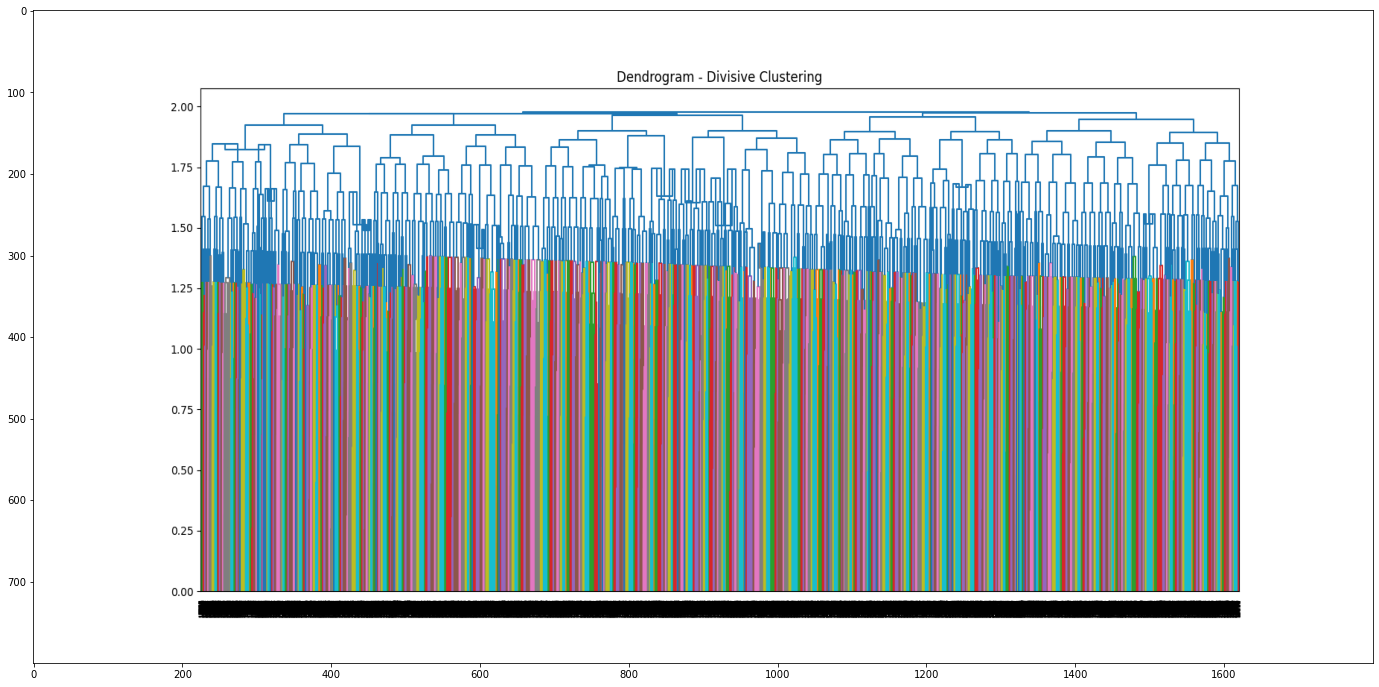

In [8]:
# reading png image file
im = img.imread('dendrogram_divisive.png')
  
# show image
fig, ax = plt.subplots(figsize=(24, 12))
ax.imshow(im, aspect='auto')